In [1]:
#loading required data
import pickle as pkl

with open("../resources/annotated_data.pickle","rb") as pkl_in:
    data = pkl.load(pkl_in)
    text = pkl.load(pkl_in)
    lu = pkl.load(pkl_in)

with open("../resources/sentence_features_en.pickle", "rb") as pkl_en:
    en_fn_features = pkl.load(pkl_en)
    en_fe_features = pkl.load(pkl_en)
    total_en = pkl.load(pkl_en)
    en_lu_ft = pkl.load(pkl_en)
    en_fe_lu_ft = pkl.load(pkl_en)
    en_lu_bert = pkl.load(pkl_en)
    
with open("../resources/sentence_features_pt.pickle", "rb") as pkl_pt:
    pt_fn_features = pkl.load(pkl_pt)
    pt_fe_features = pkl.load(pkl_pt)
    total_pt = pkl.load(pkl_pt)
    pt_lu_ft = pkl.load(pkl_pt)
    pt_fe_lu_ft = pkl.load(pkl_pt)
    pt_lu_bert = pkl.load(pkl_pt)
    
with open("../resources/sentence_features_de.pickle", "rb") as pkl_de:
    de_fn_features = pkl.load(pkl_de)
    de_fe_features = pkl.load(pkl_de)
    total_de = pkl.load(pkl_de)
    de_lu_ft = pkl.load(pkl_de)
    de_fe_lu_ft = pkl.load(pkl_de)
    de_lu_bert = pkl.load(pkl_de)

with open("../resources/bert_embeddings.pickle","rb") as pkl_in:
    lu_dict_en = pkl.load(pkl_in)
    sent_dict_en = pkl.load(pkl_in)
    lu_dict_pt = pkl.load(pkl_in)
    sent_dict_pt = pkl.load(pkl_in)
    lu_dict_de = pkl.load(pkl_in)
    sent_dict_de = pkl.load(pkl_in)

In [2]:
def get_score(df):
    df = df.fillna(0) #fills NaN values with 0s, #let us give annotator confusion a score of 0
    df = df.drop([0], axis = 1) #drops first column which contains annotator ID
    sent = df.iloc[0] #gets first row
    sent = list(sent)
    df = df.drop([0], axis = 0) #drops first column which contains the sentence pairs -- shifted to row 0 because we chose header = None 
    
    #calculating scores of each sentence pair by taking weighted average of the different scores given by 7 annotators
    scores = {}
    for i in range(len(df.columns) + 1):
        if i == 0:
            continue
        df[i] = pd.to_numeric(df[i])
        key = sent[i - 1].split('[')[0]
        scores[key] = (df[i] - 1).sum()/((4 - 1)*len(df))
        
    return scores, sent

In [3]:
import nltk
#nltk.download('punkt') --- uncomment when running the code for the first time
def key_generator(lang1, lang2, merged_sent, sent_dict_1, sent_dict_2):
    
    key1 = ''
    key2 = ''
    
    sents = merged_sent.split('  ')
    #print("Sents : ",sents)
    
    if lang1 == 'en':
        try:
            key1 = str(sent_dict_1[sents[0].split('EN: ')[1].strip()]) + '_en'

        #if multiple sentences of English correspond to a single sentence of Lang2
        except:
            temp = sents[0].split(':')[1].strip()
            sent_text = nltk.sent_tokenize(temp)

            #get keys of the multiple sentences
            for j in range(len(sent_text)):
                if key1 == '':
                    key1 = str(sent_dict_1[sent_text[j]]) + '_en'
                else:
                    key1 = key1 + '-' + str(sent_dict_1[sent_text[j]]) + '_en'
                    
        #print(key1)
    
    if lang2 == 'pt':
        try:
            key2 = str(sent_dict_2[sents[1].split('PT: ')[1].strip()]) + '_pt'

        #if multiple sentences of Portuguese correspond to a single sentence of English
        except:
            temp = sents[1].split(':')[1].strip()

            #nltk tokenizer doesn't split sentences based on '...' , special case handling
            if '...' in temp:
                sent_text = temp.split('...')

                #when the split is happening, after splitting, there will always be even no. of items. The i%2 == 0 th item will be having the '...' sign based on which the split happened.
                for k in range(len(sent_text)):
                    if k % 2 == 0 :
                        sent_text[k] = sent_text[k] + '...'
            else:
                sent_text = nltk.sent_tokenize(temp)

            #get keys of multiple sentences
            for j in range(len(sent_text)):
                if key2 == '':
                    key2 = str(sent_dict_2[sent_text[j].strip()]) + '_pt'
                else:
                    key2 = key2 + '-' + str(sent_dict_2[sent_text[j].strip()]) + '_pt'
                    
    elif lang2 == 'de':
        try:
            key2 = str(sent_dict_2[sents[1].split('DE:')[1].strip().replace(u'\xa0', u' ')]) + '_de'

        #if multiple sentences of English correspond to a single sentence of Lang2
        except:
            temp = sents[1].split(':')[1].strip()
            temp = temp.replace(u'\xa0', u' ')
            sent_text = nltk.sent_tokenize(temp)

            #get keys of the multiple sentences
            for j in range(len(sent_text)):
                if key2 == '':
                    key2 = str(sent_dict_2[sent_text[j]]) + '_de'
                else:
                    key2 = key2 + '-' + str(sent_dict_2[sent_text[j]]) + '_de'
    return key1, key2

In [4]:
# generating format for regressor
import pandas as pd
import numpy as np
def get_features(lang, sent_dict_1, sent_dict_2, aligned, score_choice):
    
    data_final = {}
    
    if lang == 'en-pt':
        
        df_pt = pd.read_csv('../resources/results-survey-en-pt.csv', header = None)
        k1 = {v : k for k, v in sent_dict_1.items()}  #sentid : sentence
        k2 = {v : k for k, v in sent_dict_2.items()}
                
        if score_choice == 1:
            scores, key_list = get_score(df_pt)
            key_list_extra = ['EN: ' + k1[aligned[i][0]] + '  ' + 'PT: ' + k2[aligned[i][1]] for i in range(len(aligned))]
            key_list = key_list + key_list_extra
        else:
            k1 = list(sent_dict_1.keys())
            k2 = list(sent_dict_2.keys())
            key_list = ['EN: ' + k1[i] + '  ' + 'PT: ' + k2[i] for i in range(len(k1))]
        
        
        for i in range(len(key_list)):
            #print(key_list[i])
            if score_choice == 1:
                try:
                    key_list[i] = key_list[i].split('[')[0]
                except:
                    pass
                
            en_key, pt_key = key_generator('en', 'pt', key_list[i], sent_dict_1, sent_dict_2)
            #print(en_key, pt_key)
            gen_key = en_key + '--' + pt_key
            #print(gen_key)
            data_final[gen_key] = {}
            
            temp1 = en_key.split('-')
            temp2 = pt_key.split('-')
            #print(en_key, pt_key)
            #print(len(temp1),temp1, temp2)
            
            f1 = []
            f2 = []
            f3 = []
            f4 = []
            f5 = []
            f6 = []
            f7 = []
            f8 = []
            f9 = []
            f10 = []
            
            #if sentence mapping is 1:1
            if len(temp1) == 1:
                data_final[gen_key]['lang1_fn_ft'] = en_fn_features[en_key]
                data_final[gen_key]['lang1_fe_ft'] = en_fe_features[en_key]
                data_final[gen_key]['lang1_total_ft'] = total_en[en_key]
                data_final[gen_key]['lang1_lu_ft'] = en_lu_ft[en_key]
                data_final[gen_key]['lang1_fe_lu_ft'] = en_fe_lu_ft[en_key]
                
            #if sentence mapping is n:1
            else:

                for j in range(len(temp1) - 1):
                    print('English key - ', temp1[j])
                    f1.append(en_fn_features[temp1[j]])
                    f3.append(en_fe_features[temp1[j]])
                    f5.append(total_en[temp1[j]])
                    f7.append(en_lu_ft[temp1[j]])
                    f9.append(en_fe_lu_ft[temp1[j]])

                data_final[gen_key]['lang1_fn_ft'] = np.average(f1, axis = 0)
                data_final[gen_key]['lang1_fe_ft'] = np.average(f3, axis = 0)
                data_final[gen_key]['lang1_total_ft'] = np.average(f5, axis = 0)
                data_final[gen_key]['lang1_lu_ft'] = np.average(f7, axis = 0)
                data_final[gen_key]['lang1_fe_lu_ft'] = np.average(f9, axis = 0)

            if len(temp2) == 1:
                data_final[gen_key]['lang2_fn_ft'] = pt_fn_features[pt_key]
                data_final[gen_key]['lang2_fe_ft'] = pt_fe_features[pt_key]
                data_final[gen_key]['lang2_total_ft'] = total_pt[pt_key]
                data_final[gen_key]['lang2_lu_ft'] = pt_lu_ft[pt_key]
                data_final[gen_key]['lang2_fe_lu_ft'] = pt_fe_lu_ft[pt_key]
                
            else:
                for j in range(len(temp2) - 1):

                    f2.append(pt_fn_features[temp2[j]])
                    f4.append(pt_fe_features[temp2[j]])
                    f6.append(total_pt[temp2[j]])
                    f8.append(pt_lu_ft[temp2[j]])
                    f10.append(pt_fe_lu_ft[temp2[j]])         

                data_final[gen_key]['lang2_fn_ft'] = np.average(f2, axis = 0)
                data_final[gen_key]['lang2_fe_ft'] = np.average(f4, axis = 0)
                data_final[gen_key]['lang2_total_ft'] = np.average(f6, axis = 0)
                data_final[gen_key]['lang2_lu_ft'] = np.average(f8, axis = 0)
                data_final[gen_key]['lang2_fe_lu_ft'] = np.average(f10, axis = 0)

            if score_choice == 1 :
                try:
                    data_final[gen_key]['y'] = scores[key_list[i].split('[')[0]]
                except:
                    data_final[gen_key]['y'] = 10.0    #a dummy score of 10 is assigned to sentences with no human annotated score
            else:
                data_final[gen_key]['y'] = 0.0

            #print(df_pt)
    
    elif lang == 'en-de':
        
        df_de = pd.read_csv('../resources/results-survey-en-de.csv', header = None)
        k1 = {v : k for k, v in sent_dict_1.items()}
        k2 = {v : k for k, v in sent_dict_2.items()}
        
        if score_choice == 1:
            scores, key_list = get_score(df_de)
            key_list_extra = ['EN: ' + k1[aligned[i][0]] + '  ' + 'DE: ' + k2[aligned[i][1]] for i in range(len(aligned))]
            key_list = key_list + key_list_extra
        else:
            k1 = list(sent_dict_1.keys())
            k2 = list(sent_dict_2.keys())
            key_list = ['EN: ' + k1[i] + '  ' + 'DE: ' + k2[i] for i in range(len(k1))]
        
        for i in range(len(key_list)):
            #print(key_list[i])
            en_key, de_key = key_generator('en', 'de', key_list[i], sent_dict_1, sent_dict_2)    
            gen_key = en_key + '--' + de_key
            data_final[gen_key] = {}

            temp1 = en_key.split('-')
            temp2 = de_key.split('-')
            
            f1 = []
            f2 = []
            f3 = []
            f4 = []
            f5 = []
            f6 = []
            f7 = []
            f8 = []
            f9 = []
            f10 = []
            
            if len(temp1) == 1:
                data_final[gen_key]['lang1_fn_ft'] = en_fn_features[en_key]
                data_final[gen_key]['lang1_fe_ft'] = en_fe_features[en_key]
                data_final[gen_key]['lang1_total_ft'] = total_en[en_key]
                data_final[gen_key]['lang1_lu_ft'] = en_lu_ft[en_key]
                data_final[gen_key]['lang1_fe_lu_ft'] = en_fe_lu_ft[en_key]
                
            else:
                for j in range(len(temp1) - 1):

                    f1.append(en_fn_features[temp1[j]])
                    f3.append(en_fe_features[temp1[j]])
                    f5.append(total_en[temp1[j]])
                    f7.append(en_lu_ft[temp1[j]])
                    f9.append(en_fe_lu_ft[temp1[j]])

                data_final[gen_key]['lang1_fn_ft'] = np.average(f1, axis = 0)
                data_final[gen_key]['lang1_fe_ft'] = np.average(f3, axis = 0)
                data_final[gen_key]['lang1_total_ft'] = np.average(f5, axis = 0)
                data_final[gen_key]['lang1_lu_ft'] = np.average(f7, axis = 0)
                data_final[gen_key]['lang1_fe_lu_ft'] = np.average(f9, axis = 0)


            if len(temp2) == 1:
                data_final[gen_key]['lang2_fn_ft'] = de_fn_features[de_key]
                data_final[gen_key]['lang2_fe_ft'] = de_fe_features[de_key]
                data_final[gen_key]['lang2_total_ft'] = total_de[de_key]
                data_final[gen_key]['lang2_lu_ft'] = de_lu_ft[de_key]
                data_final[gen_key]['lang2_fe_lu_ft'] = de_fe_lu_ft[de_key]
                
            else:
                for j in range(len(temp2) - 1):

                    f2.append(de_fn_features[temp2[j]])
                    f4.append(de_fe_features[temp2[j]])
                    f6.append(total_pt[temp2[j]])
                    f8.append(de_lu_ft[temp2[j]])
                    f10.append(de_fe_lu_ft[temp2[j]])         

                data_final[gen_key]['lang2_fn_ft'] = np.average(f2, axis = 0)
                data_final[gen_key]['lang2_fe_ft'] = np.average(f4, axis = 0)
                data_final[gen_key]['lang2_total_ft'] = np.average(f6, axis = 0)
                data_final[gen_key]['lang2_lu_ft'] = np.average(f8, axis = 0)
                data_final[gen_key]['lang2_fe_lu_ft'] = np.average(f10, axis = 0)

            if score_choice == 1:
                try:
                    data_final[gen_key]['y'] = scores[key_list[i]]
                except:
                    data_final[gen_key]['y'] = 10.0
            else:
                data_final[gen_key]['y'] = 0.0

        #print(df_de)

    return data_final

In [5]:
# generating format for regressor
import pandas as pd
import numpy as np
def get_features_bert(lang, sent_dict_1, sent_dict_2, aligned, score_choice):
    
    data_final = {}
    sent_index_1 = {str(v) : k for k, v in sent_dict_1.items()}
    sent_index_2 = {str(v) : k for k, v in sent_dict_2.items()}
    
    if lang == 'en-pt':
        
        df_pt = pd.read_csv('../resources/results-survey-en-pt.csv', header = None)
        k1 = {v : k for k, v in sent_dict_1.items()}  #sentid : sentence
        k2 = {v : k for k, v in sent_dict_2.items()}
                
        if score_choice == 1:
            scores, key_list = get_score(df_pt)
            key_list_extra = ['EN: ' + k1[aligned[i][0]] + '  ' + 'PT: ' + k2[aligned[i][1]] for i in range(len(aligned))]
            key_list = key_list + key_list_extra
        else:
            k1 = list(sent_dict_1.keys())
            k2 = list(sent_dict_2.keys())
            key_list = ['EN: ' + k1[i] + '  ' + 'PT: ' + k2[i] for i in range(len(k1))]
        
        #print(key_list)
        for i in range(len(key_list)):
            
            if score_choice == 1:
                try:
                    key_list[i] = key_list[i].split('[')[0]
                except:
                    pass
            
            en_key, pt_key = key_generator('en', 'pt', key_list[i], sent_dict_1, sent_dict_2)
            #print(en_key, pt_key)
            gen_key = en_key + '--' + pt_key
            #print(gen_key)
            data_final[gen_key] = {}
            
            temp1 = en_key.split('-')
            temp2 = pt_key.split('-')
            #print(en_key, pt_key)
            #print(len(temp1),temp1, temp2)
            
            f1 = []
            f2 = []
            f3 = []
            f4 = []
            f5 = []
            f6 = []
            f7 = []
            f8 = []
            #f9 = []
            #f10 = []
            
            #if sentence mapping is 1:1
            if len(temp1) == 1:
                data_final[gen_key]['lang1_fn_ft'] = en_fn_features[en_key]
                data_final[gen_key]['lang1_fe_ft'] = en_fe_features[en_key]
                try:
                    data_final[gen_key]['lang1_sent_ft'] = sent_dict_en[sent_index_1[en_key.replace('_en','')]][0]
                except:
                    data_final[gen_key]['lang1_sent_ft'] = np.zeros(768)
                data_final[gen_key]['lang1_lu_ft'] = en_lu_bert[en_key]
                #data_final[gen_key]['lang1_fe_lu_ft'] = en_fe_lu_ft[en_key]
                
            #if sentence mapping is n:1
            else:

                for j in range(len(temp1) - 1):
                    print('English key - ', temp1[j])
                    f1.append(en_fn_features[temp1[j]])
                    f3.append(en_fe_features[temp1[j]])
                    try:
                        f5.append(sent_dict_en[sent_index_1[temp1[j].replace('_en','')]][0])
                    except:
                        f5.append(np.zeros(768))
                    f7.append(en_lu_bert[temp1[j]])
                    #f9.append(en_fe_lu_ft[temp1[j]])

                data_final[gen_key]['lang1_fn_ft'] = np.average(f1, axis = 0)
                data_final[gen_key]['lang1_fe_ft'] = np.average(f3, axis = 0)
                data_final[gen_key]['lang1_sent_ft'] = np.average(f5, axis = 0)
                data_final[gen_key]['lang1_lu_ft'] = np.average(f7, axis = 0)
                #data_final[gen_key]['lang1_fe_lu_ft'] = np.average(f9, axis = 0)

            if len(temp2) == 1:
                data_final[gen_key]['lang2_fn_ft'] = pt_fn_features[pt_key]
                data_final[gen_key]['lang2_fe_ft'] = pt_fe_features[pt_key]
                try:
                    data_final[gen_key]['lang2_sent_ft'] = sent_dict_pt[sent_index_2[pt_key.replace('_pt','')]][0]
                except:
                    data_final[gen_key]['lang2_sent_ft'] = np.zeros(768)
                data_final[gen_key]['lang2_lu_ft'] = pt_lu_bert[pt_key]
                #data_final[gen_key]['lang2_fe_lu_ft'] = pt_fe_lu_ft[pt_key]
                
            else:
                for j in range(len(temp2) - 1):

                    f2.append(pt_fn_features[temp2[j]])
                    f4.append(pt_fe_features[temp2[j]])
                    try:
                        f6.append(sent_dict_pt[sent_index_2[temp2[j].replace('_pt','')]][0])
                    except:
                        f6.append(np.zeros(768))
                    f8.append(pt_lu_bert[temp2[j]])
                    #f10.append(pt_fe_lu_ft[temp2[j]])         

                data_final[gen_key]['lang2_fn_ft'] = np.average(f2, axis = 0)
                data_final[gen_key]['lang2_fe_ft'] = np.average(f4, axis = 0)
                data_final[gen_key]['lang2_sent_ft'] = np.average(f6, axis = 0)
                data_final[gen_key]['lang2_lu_ft'] = np.average(f8, axis = 0)
                #data_final[gen_key]['lang2_fe_lu_ft'] = np.average(f10, axis = 0)

            if score_choice == 1 :
                try:
                    data_final[gen_key]['y'] = scores[key_list[i].split('[')[0]]
                except:
                    data_final[gen_key]['y'] = 10.0
            else:
                data_final[gen_key]['y'] = 0.0

            #print(df_pt)
    
    elif lang == 'en-de':
        
        df_de = pd.read_csv('../resources/results-survey-en-de.csv', header = None)
        k1 = {v : k for k, v in sent_dict_1.items()}
        k2 = {v : k for k, v in sent_dict_2.items()}
        
        if score_choice == 1:
            scores, key_list = get_score(df_de)
            key_list_extra = ['EN: ' + k1[aligned[i][0]] + '  ' + 'DE: ' + k2[aligned[i][1]] for i in range(len(aligned))]
            key_list = key_list + key_list_extra
        else:
            k1 = list(sent_dict_1.keys())
            k2 = list(sent_dict_2.keys())
            key_list = ['EN: ' + k1[i] + '  ' + 'DE: ' + k2[i] for i in range(len(k1))]
        
        for i in range(len(key_list)):
        
            en_key, de_key = key_generator('en', 'de', key_list[i], sent_dict_1, sent_dict_2)    
            gen_key = en_key + '--' + de_key
            data_final[gen_key] = {}

            temp1 = en_key.split('-')
            temp2 = de_key.split('-')
            
            f1 = []
            f2 = []
            f3 = []
            f4 = []
            f5 = []
            f6 = []
            f7 = []
            f8 = []
            #f9 = []
            #f10 = []
            
            if len(temp1) == 1:
                data_final[gen_key]['lang1_fn_ft'] = en_fn_features[en_key]
                data_final[gen_key]['lang1_fe_ft'] = en_fe_features[en_key]
                try:
                    data_final[gen_key]['lang1_sent_ft'] = sent_dict_en[sent_index_1[en_key.replace('_en','')]][0]
                except:
                    data_final[gen_key]['lang1_sent_ft'] = np.zeros(768)
                data_final[gen_key]['lang1_lu_ft'] = en_lu_bert[en_key]
                #data_final[gen_key]['lang1_fe_lu_ft'] = en_fe_lu_ft[en_key]
                
            else:
                for j in range(len(temp1) - 1):

                    f1.append(en_fn_features[temp1[j]])
                    f3.append(en_fe_features[temp1[j]])
                    try:
                        f5.append(sent_dict_en[sent_index_1[temp1[j].replace('_en','')]][0])
                    except:
                        f5.append(np.zeros(768))
                    f7.append(en_lu_bert[temp1[j]])
                    #f9.append(en_fe_lu_ft[temp1[j]])

                data_final[gen_key]['lang1_fn_ft'] = np.average(f1, axis = 0)
                data_final[gen_key]['lang1_fe_ft'] = np.average(f3, axis = 0)
                data_final[gen_key]['lang1_sent_ft'] = np.average(f5, axis = 0)
                data_final[gen_key]['lang1_lu_ft'] = np.average(f7, axis = 0)
                #data_final[gen_key]['lang1_fe_lu_ft'] = np.average(f9, axis = 0)


            if len(temp2) == 1:
                data_final[gen_key]['lang2_fn_ft'] = de_fn_features[de_key]
                data_final[gen_key]['lang2_fe_ft'] = de_fe_features[de_key]
                try:
                    data_final[gen_key]['lang2_sent_ft'] = sent_dict_de[sent_index_2[de_key.replace('_de','')]][0]
                except:
                    data_final[gen_key]['lang2_sent_ft'] = np.zeros(768)
                data_final[gen_key]['lang2_lu_ft'] = de_lu_bert[de_key]
                #data_final[gen_key]['lang2_fe_lu_ft'] = de_fe_lu_ft[de_key]
                
            else:
                for j in range(len(temp2) - 1):

                    f2.append(de_fn_features[temp2[j]])
                    f4.append(de_fe_features[temp2[j]])
                    try:
                        f6.append(sent_dict_de[sent_index_2[temp2[j].replace('_de','')]][0])
                    except:
                        f6.append(np.zeros(768))
                    f8.append(de_lu_bert[temp2[j]])
                    #f10.append(de_fe_lu_ft[temp2[j]])         

                data_final[gen_key]['lang2_fn_ft'] = np.average(f2, axis = 0)
                data_final[gen_key]['lang2_fe_ft'] = np.average(f4, axis = 0)
                data_final[gen_key]['lang2_sent_ft'] = np.average(f6, axis = 0)
                data_final[gen_key]['lang2_lu_ft'] = np.average(f8, axis = 0)
                #data_final[gen_key]['lang2_fe_lu_ft'] = np.average(f10, axis = 0)

            if score_choice == 1:
                try:
                    data_final[gen_key]['y'] = scores[key_list[i]]
                except:
                    data_final[gen_key]['y'] = 10.0
            else:
                data_final[gen_key]['y'] = 0.0

        #print(df_de)

    return data_final

In [6]:
#def main():
      
df_prime = pd.read_csv("../resources/en-pt-de.csv", skiprows = 1, names = ["En_Id","En_Sentence","Pt_Id","Pt_Sentence","De_Id","De_Sentence"], encoding = 'utf-8')

#English - Portuguese
df = pd.read_csv("../resources/en-pt.csv", skiprows = 1, names = ["En_Id","En_Sentence","Pt_Id","Pt_Sentence"], encoding = 'utf-8')

#getting subsets of the original dataframe
df_en = df[[col for col in df.columns if "Pt_Id" not in col and 'Pt_Sentence' not in col]]
df_pt = df[[col for col in df.columns if "En_Id" not in col and 'En_Sentence' not in col]]

#keeping the unscored sentences separate
aligned_enpt_extra = [(row["En_Id"], row["Pt_Id"]) for index, row in df.iterrows() if row['En_Id'] not in df_prime['En_Id'].values and row['Pt_Id'] not in df_prime['Pt_Id'].values]

#Deutsche
df = pd.read_csv("../resources/en-de.csv", skiprows = 1, names = ["En_Id","En_Sentence","De_Id","De_Sentence"], encoding = 'utf-8')

df_de = df[[col for col in df.columns if "En_Id" not in col and 'En_Sentence' not in col]]

#keeping the unscored sentences separate
aligned_ende_extra = [(row["En_Id"], row["De_Id"]) for index, row in df.iterrows() if row['En_Id'] not in df_prime['En_Id'].values and row['De_Id'] not in df_prime['De_Id'].values]

#retrieving sentence id from sentences
#key = sentence, value = sentence id
key_set_en = df_en.set_index('En_Sentence').to_dict()['En_Id']
key_set_en = {k.strip() : v for k, v in key_set_en.items()}
key_set_pt = df_pt.set_index('Pt_Sentence').to_dict()['Pt_Id']
key_set_pt = {k.strip() : v for k, v in key_set_pt.items()}
key_set_de = df_de.set_index('De_Sentence').to_dict()['De_Id']

# Deutsche script contained \xa0 which is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160). We replace it with a space.
key_set_de = {k.replace(u'\xa0', u' ') : v for k,v in key_set_de.items()} 

#using fasttext
data_en_pt = get_features('en-pt', key_set_en, key_set_pt, aligned_enpt_extra, 1)  #key_pt contains en as well
data_en_de = get_features('en-de', key_set_en, key_set_de, aligned_ende_extra, 1)

#using bert
data_en_pt_bert = get_features_bert('en-pt', key_set_en, key_set_pt, aligned_enpt_extra, 1)  #key_pt contains en as well
data_en_de_bert = get_features_bert('en-de', key_set_en, key_set_de, aligned_ende_extra, 1)

#if __name__ == '__main__':
#    main()

English key -  1028_en
English key -  1031_en
English key -  1028_en
English key -  1031_en


In [7]:
#generate negative samples
from random import sample, seed

seed(25)

neg_samples_en = sample(list(key_set_en), 10) 
#print(neg_samples_en)
neg_samples_pt = sample(list(key_set_pt), 10) 
#print(neg_samples_pt)
neg_samples_de = sample(list(key_set_de), 10) 
#print(neg_samples_de)

neg_set_en = {sent : key_set_en[sent] for sent in neg_samples_en}
neg_set_pt = {sent : key_set_pt[sent] for sent in neg_samples_pt}
neg_set_de = {sent : key_set_de[sent] for sent in neg_samples_de}

neg_en_pt = get_features('en-pt', neg_set_en, neg_set_pt, aligned_enpt_extra, 0)
neg_en_de = get_features('en-de', neg_set_en, neg_set_de, aligned_ende_extra, 0)

#using bert
neg_en_pt_bert = get_features_bert('en-pt', neg_set_en, neg_set_pt, aligned_enpt_extra, 0)  #key_pt contains en as well
neg_en_de_bert = get_features_bert('en-de', neg_set_en, neg_set_de, aligned_ende_extra, 0)

In [8]:
#merging data

print(len(data_en_pt), len(neg_en_pt))
final_data_en_pt = {**data_en_pt, **neg_en_pt}
print(len(final_data_en_pt))

print(len(data_en_de), len(neg_en_de))
final_data_en_de = {**data_en_de, **neg_en_de}
print(len({**data_en_de, **neg_en_de}))

final_pos_data_ft = {**data_en_pt, **data_en_de}
print("Original Data with FastText Sample size : ", len(final_pos_data_ft))

final_pos_data_bert = {**data_en_pt_bert, **data_en_de_bert}
print("Original Data with Bert Sample size : ", len(final_pos_data_bert))

final_data = {**data_en_pt_bert, **neg_en_pt_bert, **data_en_de_bert, **neg_en_de_bert}
print("Final Sample size : ", len(final_data))

282 10
292
55 10
65
Original Data with FastText Sample size :  337
Original Data with Bert Sample size :  337
Final Sample size :  357


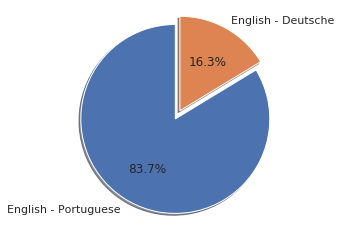

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

labels = "English - Portuguese ", "English - Deutsche"
explode = (0, 0.1)
sizes = [len(data_en_pt), len(data_en_de)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [10]:
with open("../resources/final_data.pickle", "wb") as pkl_out:
    pkl.dump(data_en_pt, pkl_out)
    pkl.dump(data_en_de, pkl_out)
    pkl.dump(final_data_en_pt, pkl_out)
    pkl.dump(final_data_en_de, pkl_out)
    pkl.dump(final_pos_data_ft, pkl_out)
    pkl.dump(final_pos_data_bert, pkl_out)
    pkl.dump(final_data, pkl_out)